# Pruebas base multivariadas

Baseline Definitivo: AR(21) + UST10Y + RSI para USD/PEN

Este notebook presenta la justificación rigurosa del baseline final
mediante 3 fases:
1. LASSO Feature Selection (justificación de AR(21))
2. Backward Selection por p-values (selección de exógenas)
3. Walk-Forward Validation (validación robusta)

Autor: [Tu Nombre]
Fecha: Octubre 2025

In [21]:
# ============================================================================
# IMPORTS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Agregar después de: from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import os
import json
from datetime import datetime

# Statsmodels
from statsmodels.tsa.arima.model import ARIMA

# ARCH (para GARCH)
from arch import arch_model

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================================
# CLASE: MÉTRICAS DE FORECASTING FX
# ============================================================================

class FXMetrics:
    """
    Métricas especializadas para evaluación de forecasting FX
    """
    
    @staticmethod
    def mase(y_true: np.ndarray, y_pred: np.ndarray, y_train: np.ndarray) -> float:
        """
        Mean Absolute Scaled Error
        MASE < 1.0 significa que el modelo supera al naive forecast
        """
        mae_model = np.mean(np.abs(y_true - y_pred))
        mae_naive = np.mean(np.abs(np.diff(y_train)))
        return np.inf if mae_naive == 0 else mae_model / mae_naive
    
    @staticmethod
    def directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Directional Accuracy (DA)
        DA > 50% significa capacidad predictiva direccional
        """
        return 100.0 * np.mean(np.sign(y_true) == np.sign(y_pred))
    
    @staticmethod
    def theils_u(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Theil's U statistic"""
        rmse_model = np.sqrt(np.mean((y_true - y_pred)**2))
        if len(y_true) > 1:
            y_naive = np.concatenate([[y_true[0]], y_true[:-1]])
            rmse_naive = np.sqrt(np.mean((y_true - y_naive)**2))
        else:
            rmse_naive = rmse_model
        return rmse_model / (rmse_naive + 1e-10)
    
    @staticmethod
    def all_metrics(y_true: np.ndarray, y_pred: np.ndarray, 
                   y_train: np.ndarray) -> Dict[str, float]:
        """Calcula todas las métricas"""
        return {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MASE': FXMetrics.mase(y_true, y_pred, y_train),
            'DA': FXMetrics.directional_accuracy(y_true, y_pred),
            'TheilU': FXMetrics.theils_u(y_true, y_pred)
        }


In [22]:
# ============================================================================
# FUNCIÓN DE EXPORTACIÓN PARA META-LEARNER
# ============================================================================

def save_oof_predictions(predictions, dates, actuals, model_name='ARX',
                         prediction_type='log_returns', metadata=None,
                         output_dir='oof_predictions'):
    """
    Guarda predicciones OOF en formato estándar para meta-learner.
    
    Args:
        predictions: array con predicciones OOF
        dates: array con fechas
        actuals: array con valores reales
        model_name: nombre del modelo
        prediction_type: 'log_returns' o 'levels'
        metadata: dict con info adicional
        output_dir: directorio de salida
    """
    # Crear directorio
    os.makedirs(output_dir, exist_ok=True)
    
    # Crear DataFrame
    df_oof = pd.DataFrame({
        'ds': dates,
        'y_pred': predictions,
        'y_real': actuals,
        'model': model_name,
        'type': prediction_type
    })
    
    # Guardar CSV
    filename = f'train_oof_{model_name}.csv'
    filepath = os.path.join(output_dir, filename)
    df_oof.to_csv(filepath, index=False)
    
    # Guardar metadata
    if metadata is not None:
        metadata['timestamp'] = datetime.now().isoformat()
        metadata['n_observations'] = len(predictions)
        
        meta_filename = f'train_oof_{model_name}_metadata.json'
        meta_filepath = os.path.join(output_dir, meta_filename)
        
        with open(meta_filepath, 'w') as f:
            json.dump(metadata, f, indent=2)
    
    print(f"\n✅ Guardado OOF: {filename}")
    print(f"   📊 Observaciones: {len(predictions)}")
    print(f"   📅 Rango: {dates[0]} a {dates[-1]}")
    
    return filepath


def export_model_predictions(dates, y_pred, model_name, prediction_type, output_dir='predictions_dump'):
    """
    Guarda las predicciones crudas para el Meta-Learner.
    
    Args:
        dates (array-like): Fechas del holdout (deben ser 60).
        y_pred (array-like): Valores predichos (Niveles o Retornos, según el modelo).
        model_name (str): Nombre único (ej: 'CatBoost', 'NHITS').
        prediction_type (str): 'levels' o 'log_returns' (para saber qué transformación aplicar luego).
        output_dir (str): Carpeta donde se guardarán los CSVs.
    """
    from pathlib import Path
    
    # Crear carpeta si no existe
    save_path = Path(output_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    filename = save_path / f"pred_{model_name}.csv"
    
    # Crear DataFrame ligero
    df_export = pd.DataFrame({
        'ds': dates,
        'y_pred': y_pred,
        'model': model_name,
        'type': prediction_type
    })
    
    df_export.to_csv(filename, index=False)
    print(f"✅ [EXPORT] Predicciones guardadas en: {filename}")
    print(f"   - Dimensiones: {df_export.shape}")
    print(f"   - Tipo: {prediction_type}")

print("✓ Función export_model_predictions cargada")

✓ Función export_model_predictions cargada


In [23]:
# ============================================================================
# CLASE: FEATURES TÉCNICOS SIN LEAKAGE
# ============================================================================

class TechnicalFeatures:
    """
    Calcula indicadores técnicos sin data leakage
    Todos los indicadores usan solo información disponible hasta t-1
    """
    
    @staticmethod
    def calculate_garch_volatility(returns: pd.Series, window: int = 252) -> pd.Series:
        """
        Volatilidad GARCH(1,1) con forecast 1-step ahead
        CORRECTO: usa forecast(horizon=1) para predicción sin leakage
        """
        volatility = pd.Series(index=returns.index, dtype=float)
        
        for i in range(window, len(returns)):
            try:
                returns_window = returns.iloc[i-window:i] * 100
                model = arch_model(returns_window, vol='Garch', p=1, q=1)
                model_fit = model.fit(disp='off', show_warning=False)
                forecast = model_fit.forecast(horizon=1)
                volatility.iloc[i] = np.sqrt(forecast.variance.values[-1, 0]) / 100
            except:
                volatility.iloc[i] = returns.iloc[i-window:i].std()
        
        return volatility
    
    @staticmethod
    def calculate_sma(prices: pd.Series, windows: List[int]) -> pd.DataFrame:
        """
        Simple Moving Averages SIN LEAKAGE
        CORRECTO: usa prices.shift(1) antes de calcular rolling
        """
        sma_df = pd.DataFrame(index=prices.index)
        
        for w in windows:
            # SMA calculada con precios hasta t-1
            sma_df[f'SMA_{w}'] = prices.shift(1).rolling(window=w).mean()
            
            # Diferencia: precio de ayer vs SMA de ayer
            price_lagged = prices.shift(1)
            sma_df[f'price_vs_SMA_{w}'] = (price_lagged - sma_df[f'SMA_{w}']) / sma_df[f'SMA_{w}']
        
        return sma_df
    
    @staticmethod
    def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
        """
        Relative Strength Index SIN LEAKAGE
        CORRECTO: calcula delta sobre prices.shift(1)
        """
        prices_lagged = prices.shift(1)
        delta = prices_lagged.diff()
        
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        # Normalizar a [-1, 1]
        rsi_normalized = (rsi - 50) / 50
        
        return rsi_normalized
    
    @staticmethod
    def calculate_macd(prices: pd.Series, fast: int = 12, slow: int = 26, 
                      signal: int = 9) -> pd.DataFrame:
        """
        MACD SIN LEAKAGE
        CORRECTO: calcula EMAs sobre prices.shift(1)
        """
        prices_lagged = prices.shift(1)
        
        ema_fast = prices_lagged.ewm(span=fast, adjust=False).mean()
        ema_slow = prices_lagged.ewm(span=slow, adjust=False).mean()
        
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        
        macd_df = pd.DataFrame({
            'MACD_line': macd_line / prices_lagged,
            'MACD_histogram': histogram / prices_lagged
        })
        
        return macd_df

In [24]:
# ============================================================================
# CLASE: PROCESADOR DE DATOS
# ============================================================================

class DataProcessor:
    """
    Procesa datos USD/PEN y crea todas las variables necesarias
    """
    
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.df = None
        self.df_clean = None
        self.feature_names = None
        
    def load_and_prepare(self) -> pd.DataFrame:
        """Carga y prepara todos los features"""
        print("="*80)
        print("PROCESAMIENTO DE DATOS")
        print("="*80)
        
        # Cargar
        self.df = pd.read_csv(self.filepath)
        self.df['Dates'] = pd.to_datetime(self.df['Dates'])
        self.df = self.df.sort_values('Dates').reset_index(drop=True)
        print(f"\n1. Datos cargados: {len(self.df)} observaciones")
        
        # Target: PEN log returns
        self.df['PEN_log_ret'] = np.log(self.df['PEN'] / self.df['PEN'].shift(1))
        
        # Variables FX (log returns)
        print("\n2. Creando variables FX...")
        price_vars = ['MXN', 'CLP', 'COBRE', 'MXPE']
        for var in price_vars:
            self.df[f'{var}_log_ret'] = np.log(self.df[var] / self.df[var].shift(1))
        
        # Variables macro (diferencias)
        print("3. Creando variables macro...")
        rate_vars = ['DXY', 'UST10Y']
        for var in rate_vars:
            self.df[f'{var}_diff'] = self.df[var].diff()
        
        # Variables técnicas (sin leakage)
        print("4. Creando variables técnicas (sin leakage)...")
        tech = TechnicalFeatures()
        
        print("   - GARCH volatility (puede tardar ~2-3 min)...")
        self.df['GARCH_vol'] = tech.calculate_garch_volatility(
            self.df['PEN_log_ret'].dropna()
        )
        
        print("   - SMAs (5, 10, 20)...")
        sma_df = tech.calculate_sma(self.df['PEN'], windows=[5, 10, 20])
        self.df = pd.concat([self.df, sma_df], axis=1)
        
        print("   - RSI...")
        self.df['RSI'] = tech.calculate_rsi(self.df['PEN'])
        
        print("   - MACD...")
        macd_df = tech.calculate_macd(self.df['PEN'])
        self.df = pd.concat([self.df, macd_df], axis=1)
        
        # Crear lags para exógenas tradicionales
        print("\n5. Creando lags (t-1) para exógenas tradicionales...")
        exog_traditional = ['MXN_log_ret', 'MXPE_log_ret', 'CLP_log_ret', 
                           'UST10Y_diff', 'COBRE_log_ret', 'DXY_diff']
        
        for feat in exog_traditional:
            self.df[f'{feat}_lag_1'] = self.df[feat].shift(1)
        
        # Variables técnicas YA están rezagadas (no necesitan lag adicional)
        
        # Limpiar NaNs
        self.df_clean = self.df.dropna().reset_index(drop=True)
        print(f"\n6. Datos limpios: {len(self.df_clean)} observaciones")
        
        # Guardar nombres de features para LASSO
        self.feature_names = {
            'traditional': [f'{v}_lag_1' for v in exog_traditional],
            'technical': ['GARCH_vol', 'price_vs_SMA_5', 'price_vs_SMA_10', 
                         'price_vs_SMA_20', 'RSI', 'MACD_line', 'MACD_histogram'],
            'target': 'PEN_log_ret'
        }
        
        print(f"\nFeatures disponibles:")
        print(f"  - Tradicionales: {len(self.feature_names['traditional'])}")
        print(f"  - Técnicos: {len(self.feature_names['technical'])}")
        print(f"  - Total exógenas: {len(self.feature_names['traditional']) + len(self.feature_names['technical'])}")
        
        return self.df_clean
    
    def get_train_test_split(self, n_holdout: int = 60) -> Tuple:
        """Divide en train/test"""
        split_idx = len(self.df_clean) - n_holdout
        train_df = self.df_clean.iloc[:split_idx].copy()
        test_df = self.df_clean.iloc[split_idx:].copy()
        
        return train_df, test_df

In [25]:
# ============================================================================
# CLASE: LASSO FEATURE SELECTION
# ============================================================================

class LASSOFeatureSelector:
    """
    Selección de features usando LASSO con cross-validation
    """
    
    def __init__(self, alphas: Optional[np.ndarray] = None):
        self.alphas = alphas if alphas is not None else np.logspace(-6, 1, 100)
        self.model = None
        self.feature_importance = None
        
    def fit(self, X: np.ndarray, y: np.ndarray, 
            feature_names: List[str]) -> pd.DataFrame:
        """
        Ajusta LASSO y retorna feature importance
        """
        print("\n" + "="*80)
        print("FASE 1: LASSO FEATURE SELECTION")
        print("="*80)
        
        # LASSO con CV
        print("\nAjustando LASSO con cross-validation...")
        lasso_cv = LassoCV(alphas=self.alphas, cv=5, random_state=RANDOM_STATE, 
                          max_iter=10000)
        lasso_cv.fit(X, y)
        
        print(f"Alpha óptimo: {lasso_cv.alpha_:.6f}")
        
        # Re-ajustar con alpha óptimo
        self.model = Lasso(alpha=lasso_cv.alpha_, random_state=RANDOM_STATE, 
                          max_iter=10000)
        self.model.fit(X, y)
        
        # Feature importance
        self.feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': np.abs(self.model.coef_),
            'coefficient_raw': self.model.coef_
        }).sort_values('coefficient', ascending=False)
        
        # Filtrar features con coef != 0
        self.feature_importance = self.feature_importance[
            self.feature_importance['coefficient'] > 0
        ].reset_index(drop=True)
        
        print(f"\nFeatures seleccionados: {len(self.feature_importance)}")
        print("\nTop 10 Features por importancia:")
        print(self.feature_importance.head(10).to_string(index=False))
        
        return self.feature_importance
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predice con LASSO"""
        return self.model.predict(X)

In [26]:
# ============================================================================
# CLASE: BACKWARD SELECTION POR P-VALUES
# ============================================================================

class BackwardSelectionARX:
    """
    Backward selection de exógenas usando p-values
    """
    
    def __init__(self, significance_level: float = 0.10):
        self.significance_level = significance_level
        self.best_ar_order = None
        self.full_model = None
        self.parsimonious_model = None
        self.selected_exog = None
        self.scaler_full = None
        self.scaler_parsimonious = None
        
    def _find_best_ar_order(self, y_train: np.ndarray, exog_train: np.ndarray) -> int:
        """Encuentra mejor orden AR por AIC"""
        best_aic = np.inf
        best_p = 21
        
        print("  Búsqueda AR(p) con p ∈ [1, 3, 5, 10, 21]:")
        
        for p in [1, 3, 5, 10, 21]:
            try:
                order = (p, 0, 0)
                model = ARIMA(y_train, order=order, exog=exog_train)
                fitted = model.fit(method='statespace', low_memory=True)
                
                print(f"    AR({p}): AIC={fitted.aic:.2f}")
                
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_p = p
            except:
                print(f"    AR({p}): falló")
        
        print(f"    → Mejor: AR({best_p}) (AIC={best_aic:.2f})")
        return best_p
    
    def fit_full_model(self, y_train: np.ndarray, exog_train: np.ndarray,
                       exog_names: List[str]) -> Dict:
        """Ajusta modelo completo con todas las exógenas"""
        print("\n" + "="*80)
        print("FASE 2: BACKWARD SELECTION POR P-VALUES")
        print("="*80)
        print("\nPASO 1: Modelo Completo (13 exógenas)")
        print("-"*80)
        
        # Escalar
        self.scaler_full = StandardScaler()
        exog_train_scaled = self.scaler_full.fit_transform(exog_train)
        
        # Encontrar mejor AR
        self.best_ar_order = self._find_best_ar_order(y_train, exog_train_scaled)
        
        # Ajustar modelo completo
        order = (self.best_ar_order, 0, 0)
        model = ARIMA(y_train, order=order, exog=exog_train_scaled)
        self.full_model = model.fit(method='statespace', low_memory=True)
        
        # Convertir params y pvalues a Series
        if isinstance(self.full_model.params, np.ndarray):
            params = pd.Series(self.full_model.params, 
                             index=self.full_model.model.param_names)
            pvalues = pd.Series(self.full_model.pvalues, 
                              index=self.full_model.model.param_names)
        else:
            params = self.full_model.params
            pvalues = self.full_model.pvalues
        
        # Extraer p-values de exógenas
        print(f"\nCoeficientes de exógenas:")
        print(f"  {'Variable':<35} {'Coef':>10} {'P-value':>10} {'Sig':<5}")
        print(f"  {'-'*35} {'-'*10} {'-'*10} {'-'*5}")
        
        exog_pvalues = {}
        
        for i, exog_name in enumerate(exog_names):
            param_key = f'x{i+1}'
            
            if param_key in pvalues.index:
                coef = params[param_key]
                pval = pvalues[param_key]
                sig = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.10 else ""
                
                exog_pvalues[exog_name] = pval
                print(f"  {exog_name:<35} {coef:>10.6f} {pval:>10.4f} {sig:<5}")
        
        return {
            'order': self.best_ar_order,
            'aic': self.full_model.aic,
            'bic': self.full_model.bic,
            'exog_pvalues': exog_pvalues
        }
    
    def select_significant_exog(self, exog_pvalues: Dict, 
                               exog_names: List[str]) -> List[str]:
        """Selecciona exógenas significativas"""
        print(f"\nPASO 2: Selección (p-value ≤ {self.significance_level})")
        print("-"*80)
        
        selected = []
        
        for exog_name in exog_names:
            pval = exog_pvalues.get(exog_name, 1.0)
            
            if pval <= self.significance_level:
                selected.append(exog_name)
                print(f"  ✓ {exog_name:<35} (p={pval:.4f})")
            else:
                print(f"  ✗ {exog_name:<35} (p={pval:.4f})")
        
        print(f"\nSeleccionadas: {len(selected)}/{len(exog_names)}")
        self.selected_exog = selected
        
        return selected
    
    def fit_parsimonious_model(self, y_train: np.ndarray, exog_train: np.ndarray,
                               selected_indices: List[int]) -> Dict:
        """Ajusta modelo parsimonioso"""
        print(f"\nPASO 3: Modelo Parsimonioso ({len(selected_indices)} exógenas)")
        print("-"*80)
        
        if len(selected_indices) == 0:
            exog_train_selected = None
        else:
            exog_train_selected = exog_train[:, selected_indices]
            self.scaler_parsimonious = StandardScaler()
            exog_train_selected = self.scaler_parsimonious.fit_transform(exog_train_selected)
        
        order = (self.best_ar_order, 0, 0)
        model = ARIMA(y_train, order=order, exog=exog_train_selected)
        self.parsimonious_model = model.fit(method='statespace', low_memory=True)
        
        print(f"  AR({self.best_ar_order})")
        print(f"  AIC: {self.parsimonious_model.aic:.2f}")
        print(f"  BIC: {self.parsimonious_model.bic:.2f}")
        
        return {
            'order': self.best_ar_order,
            'n_exog': len(selected_indices),
            'aic': self.parsimonious_model.aic,
            'bic': self.parsimonious_model.bic
        }


In [27]:
# ============================================================================
# CLASE: WALK-FORWARD VALIDATOR
# ============================================================================

class WalkForwardValidator:
    """
    Validación walk-forward para robustez
    """
    
    def __init__(self, min_train: int = 252, step_size: int = 21):
        self.min_train = min_train
        self.step_size = step_size
        
    def validate(self, df: pd.DataFrame, target_col: str, 
                exog_cols: List[str], ar_order: int,
                n_holdout: int = 60) -> Dict:
        """
        Ejecuta walk-forward validation
        """
        df_wf = df[:-n_holdout].copy()
        n_total = len(df_wf)
        n_splits = (n_total - self.min_train) // self.step_size
        
        print(f"\nWalk-Forward: {n_splits} splits (step={self.step_size} días)")
        
        predictions = []
        actuals = []
        
        for i in range(n_splits):
            train_end = self.min_train + (i * self.step_size)
            train_data = df_wf.iloc[:train_end]
            test_data = df_wf.iloc[train_end:train_end + self.step_size]
            
            if len(test_data) == 0:
                break
            
            y_train = train_data[target_col].values
            y_test = test_data[target_col].values
            
            if len(exog_cols) > 0:
                exog_train = train_data[exog_cols].values
                exog_test = test_data[exog_cols].values
                
                scaler = StandardScaler()
                exog_train = scaler.fit_transform(exog_train)
                exog_test = scaler.transform(exog_test)
            else:
                exog_train = None
                exog_test = None
            
            # Entrenar y predecir
            model = ARIMA(y_train, order=(ar_order, 0, 0), exog=exog_train)
            fitted = model.fit(method='statespace', low_memory=True)
            y_pred = fitted.forecast(steps=len(test_data), exog=exog_test)
            
            predictions.extend(y_pred)
            actuals.extend(y_test)
        
        # Métricas
        y_true = np.array(actuals)
        y_pred = np.array(predictions)
        train_full = df_wf.iloc[:self.min_train][target_col].values
        
        metrics = FXMetrics.all_metrics(y_true, y_pred, train_full)
        metrics['n_splits'] = n_splits
        
        return metrics

In [28]:
# ============================================================================
# CLASE: INTERPRETADOR DE RESULTADOS
# ============================================================================

class ResultsInterpreter:
    """
    Interpreta y visualiza resultados
    """
    
    @staticmethod
    def print_comparison_table(results: List[Dict]):
        """Imprime tabla comparativa"""
        print("\n" + "="*80)
        print("COMPARACIÓN DE MODELOS")
        print("="*80)
        
        df = pd.DataFrame(results)
        print("\n" + df.to_string(index=False))
        
        # Identificar mejor
        best_mase_idx = df['MASE'].idxmin()
        best_da_idx = df['DA'].idxmax()
        
        print(f"\nMejor MASE: {df.iloc[best_mase_idx]['modelo']} ({df.iloc[best_mase_idx]['MASE']:.4f})")
        print(f"Mejor DA: {df.iloc[best_da_idx]['modelo']} ({df.iloc[best_da_idx]['DA']:.2f}%)")
        
        # Modelos con DA>50%
        da_above_50 = df[df['DA'] > 50]
        if len(da_above_50) > 0:
            print(f"\n✓ Modelos con DA>50%:")
            for _, row in da_above_50.iterrows():
                print(f"  {row['modelo']}: DA={row['DA']:.2f}%, MASE={row['MASE']:.4f}")
        
        return df
    
    @staticmethod
    def plot_lasso_importance(feature_importance: pd.DataFrame, top_n: int = 15):
        """Gráfico 1: Feature Importance de LASSO"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        top_features = feature_importance.head(top_n)
        
        colors = ['#d62728' if 'AR' in feat or 'PEN' in feat else '#1f77b4' 
                 for feat in top_features['feature']]
        
        ax.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.invert_yaxis()
        ax.set_xlabel('Coeficiente Absoluto (LASSO)', fontsize=12, fontweight='bold')
        ax.set_title('LASSO Feature Importance\nJustificación de AR(3), AR(21) y Exógenas', 
                    fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Leyenda
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#d62728', label='Lags AR de PEN'),
            Patch(facecolor='#1f77b4', label='Exógenas')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_mase_vs_da(results_df: pd.DataFrame):
        """Gráfico 2: Trade-off MASE vs DA"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Baseline
        baseline = results_df[results_df['modelo'].str.contains('Baseline|AR\(21\) puro', regex=True)]
        
        # Otros modelos
        otros = results_df[~results_df['modelo'].str.contains('Baseline|AR\(21\) puro', regex=True)]
        
        # Modelo óptimo
        optimo = results_df[results_df['modelo'].str.contains('UST10Y \+ RSI', regex=True)]
        
        # Scatter
        if len(baseline) > 0:
            ax.scatter(baseline['DA'], baseline['MASE'], s=200, c='gray', 
                      marker='s', label='Baseline', alpha=0.7, edgecolors='black', linewidths=2)
        
        if len(otros) > 0:
            ax.scatter(otros['DA'], otros['MASE'], s=150, c='lightblue', 
                      marker='o', label='Otros modelos', alpha=0.6, edgecolors='black', linewidths=1)
        
        if len(optimo) > 0:
            ax.scatter(optimo['DA'], optimo['MASE'], s=400, c='gold', 
                      marker='*', label='Modelo Óptimo', alpha=1.0, edgecolors='black', linewidths=2)
        
        # Líneas de referencia
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='MASE=1 (Naive)')
        ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='DA=50% (Random)')
        
        # Zona óptima
        ax.fill_between([50, 100], 0, 1, alpha=0.1, color='green', label='Zona óptima')
        
        ax.set_xlabel('Directional Accuracy (DA) [%]', fontsize=12, fontweight='bold')
        ax.set_ylabel('Mean Absolute Scaled Error (MASE)', fontsize=12, fontweight='bold')
        ax.set_title('Trade-off MASE vs DA\nModelos AR(21) con Diferentes Exógenas', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Anotaciones
        for _, row in results_df.iterrows():
            if 'Óptimo' in row['modelo'] or 'UST10Y + RSI' in row['modelo']:
                ax.annotate(row['modelo'], 
                          xy=(row['DA'], row['MASE']),
                          xytext=(10, -10), textcoords='offset points',
                          fontsize=9, fontweight='bold',
                          bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_holdout_comparison(test_df: pd.DataFrame, y_test: np.ndarray,
                               y_pred_arx: np.ndarray, y_pred_lasso: np.ndarray,
                               y_pred_naive: np.ndarray):
        """Gráfico 3: Comparación en Holdout"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        dates = test_df['Dates'].values
        
        # Panel 1: Valores reales vs predicciones
        ax1 = axes[0, 0]
        ax1.plot(dates, y_test, 'k-', label='Real', linewidth=2, alpha=0.8)
        ax1.plot(dates, y_pred_arx, 'g--', label='ARX Óptimo', linewidth=2)
        ax1.plot(dates, y_pred_lasso, 'b:', label='LASSO', linewidth=2)
        ax1.plot(dates, y_pred_naive, 'r-.', label='Naive', linewidth=1.5, alpha=0.7)
        ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax1.set_ylabel('Log Returns', fontweight='bold')
        ax1.set_title('Predicciones vs Real', fontweight='bold', fontsize=12)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Panel 2: Errores
        ax2 = axes[0, 1]
        errors_arx = y_test - y_pred_arx
        errors_lasso = y_test - y_pred_lasso
        errors_naive = y_test - y_pred_naive
        
        ax2.plot(dates, errors_arx, 'g-', label='ARX Óptimo', alpha=0.7)
        ax2.plot(dates, errors_lasso, 'b-', label='LASSO', alpha=0.7)
        ax2.plot(dates, errors_naive, 'r-', label='Naive', alpha=0.5)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_ylabel('Error', fontweight='bold')
        ax2.set_title('Errores de Predicción', fontweight='bold', fontsize=12)
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # Panel 3: Acierto direccional
        ax3 = axes[1, 0]
        correct_arx = (np.sign(y_test) == np.sign(y_pred_arx)).astype(int)
        correct_lasso = (np.sign(y_test) == np.sign(y_pred_lasso)).astype(int)
        
        x_pos = np.arange(len(dates))
        width = 0.35
        
        ax3.bar(x_pos - width/2, correct_arx, width, label='ARX Óptimo', 
               color='green', alpha=0.7)
        ax3.bar(x_pos + width/2, correct_lasso, width, label='LASSO', 
               color='blue', alpha=0.7)
        ax3.set_ylabel('Acierto (1=Correcto, 0=Error)', fontweight='bold')
        ax3.set_title('Precisión Direccional por Día', fontweight='bold', fontsize=12)
        ax3.legend(loc='best')
        ax3.set_ylim([0, 1.2])
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Panel 4: Métricas acumuladas
        ax4 = axes[1, 1]
        
        metrics_data = {
            'Modelo': ['ARX Óptimo', 'LASSO', 'Naive'],
            'MASE': [
                FXMetrics.mase(y_test, y_pred_arx, y_test),
                FXMetrics.mase(y_test, y_pred_lasso, y_test),
                FXMetrics.mase(y_test, y_pred_naive, y_test)
            ],
            'DA': [
                FXMetrics.directional_accuracy(y_test, y_pred_arx),
                FXMetrics.directional_accuracy(y_test, y_pred_lasso),
                FXMetrics.directional_accuracy(y_test, y_pred_naive)
            ]
        }
        
        df_metrics = pd.DataFrame(metrics_data)
        
        x = np.arange(len(df_metrics))
        width = 0.35
        
        ax4_twin = ax4.twinx()
        
        bars1 = ax4.bar(x - width/2, df_metrics['MASE'], width, 
                       label='MASE', color='steelblue', alpha=0.8)
        bars2 = ax4_twin.bar(x + width/2, df_metrics['DA'], width, 
                            label='DA (%)', color='coral', alpha=0.8)
        
        ax4.set_xlabel('Modelo', fontweight='bold')
        ax4.set_ylabel('MASE', fontweight='bold', color='steelblue')
        ax4_twin.set_ylabel('DA (%)', fontweight='bold', color='coral')
        ax4.set_title('Comparación de Métricas', fontweight='bold', fontsize=12)
        ax4.set_xticks(x)
        ax4.set_xticklabels(df_metrics['Modelo'], rotation=15)
        
        ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax4_twin.axhline(y=50, color='red', linestyle='--', alpha=0.5, linewidth=1)
        
        # Leyenda combinada
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        return fig

In [29]:
# ============================================================================
# CLASE: PIPELINE PRINCIPAL
# ============================================================================

class USDPENPipeline:
    """
    Pipeline principal que orquesta todas las fases
    """
    
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.processor = DataProcessor(filepath)
        self.lasso_selector = None
        self.backward_selector = None
        self.results = []
    
    def generate_oof_predictions(self, min_train=252, step_size=21, output_dir='oof_predictions'):
        """
        Genera predicciones OOF usando Walk-Forward Validation.
        
        Args:
            min_train: tamaño mínimo de entrenamiento (252 = 1 año)
            step_size: paso entre ventanas (21 = 1 mes)
            output_dir: directorio para guardar OOF
            
        Returns:
            oof_predictions: array con predicciones OOF
            oof_metrics: dict con métricas OOF
        """
        print("\n" + "="*80)
        print("GENERANDO PREDICCIONES OOF (WALK-FORWARD)")
        print("="*80)
        
        # Preparar datos
        df_clean = self.processor.load_and_prepare()
        train_df, test_df = self.processor.get_train_test_split(n_holdout=60)
        
        y_train = train_df[self.processor.feature_names['target']].values
        dates_train = train_df['Dates'].values
        
        # Features óptimas: UST10Y + RSI
        optimal_exog = ['UST10Y_diff_lag_1', 'RSI']
        all_exog = (self.processor.feature_names['traditional'] + 
                   self.processor.feature_names['technical'])
        optimal_indices = [i for i, name in enumerate(all_exog) if name in optimal_exog]
        
        X_train_full = train_df[all_exog].values
        X_train_optimal = X_train_full[:, optimal_indices]
        
        # Walk-Forward Validation
        n_total = len(y_train)
        n_splits = (n_total - min_train) // step_size
        
        print(f"\nWalk-Forward: {n_splits} splits")
        print(f"   Min train: {min_train} obs")
        print(f"   Step size: {step_size} días")
        print(f"Modelo: AR(21) + {optimal_exog}\n")
        
        # Arrays para predicciones VÁLIDAS (no ceros)
        all_predictions = []
        all_actuals = []
        all_dates = []
        fold_metrics = []
        
        for i in range(n_splits):
            train_end = min_train + (i * step_size)
            test_start = train_end
            test_end = min(train_end + step_size, n_total)
            
            if test_start >= n_total:
                break
            
            # Split data
            y_tr = y_train[:train_end]
            y_val = y_train[test_start:test_end]
            X_tr = X_train_optimal[:train_end]
            X_val = X_train_optimal[test_start:test_end]
            dates_val = dates_train[test_start:test_end]
            
            if len(y_val) == 0:
                break
            
            # Normalizar
            scaler = StandardScaler()
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_val_scaled = scaler.transform(X_val)
            
            # Entrenar ARX
            try:
                model = ARIMA(y_tr, order=(21, 0, 0), exog=X_tr_scaled)
                fitted = model.fit(method='statespace', low_memory=True)
                
                # Predicciones
                preds_val = fitted.forecast(steps=len(y_val), exog=X_val_scaled)
                
                # Guardar predicciones VÁLIDAS
                all_predictions.extend(preds_val)
                all_actuals.extend(y_val)
                all_dates.extend(dates_val)
                
                # Métricas del split
                mae = mean_absolute_error(y_val, preds_val)
                da = FXMetrics.directional_accuracy(y_val, preds_val)
                
                fold_metrics.append({
                    'split': i + 1,
                    'train_size': len(y_tr),
                    'val_size': len(y_val),
                    'mae': mae,
                    'da': da
                })
                
                # Mostrar progreso cada 50 splits
                if (i + 1) % 50 == 0 or i == 0:
                    print(f"Split {i+1:>3}/{n_splits}: Train={len(y_tr):>5} | Val={len(y_val):>2} | MAE={mae:.6f} | DA={da:.1f}%")
                
            except Exception as e:
                print(f"   ⚠️ Error en split {i+1}: {str(e)}")
                continue
        
        # Convertir a arrays
        oof_predictions = np.array(all_predictions)
        oof_actuals = np.array(all_actuals)
        oof_dates = np.array(all_dates)
        
        # Verificar que no haya ceros
        n_zeros = (oof_predictions == 0).sum()
        
        # Métricas OOF globales
        mae_oof = mean_absolute_error(oof_actuals, oof_predictions)
        da_oof = FXMetrics.directional_accuracy(oof_actuals, oof_predictions)
        mase_oof = FXMetrics.mase(oof_actuals, oof_predictions, y_train[:min_train])
        
        print(f"\n{'='*60}")
        print(f"📊 MÉTRICAS OOF GLOBALES:")
        print(f"{'='*60}")
        print(f"   Observaciones: {len(oof_predictions)}")
        print(f"   Predicciones = 0: {n_zeros} {'✅' if n_zeros == 0 else '⚠️'}")
        print(f"   MAE:  {mae_oof:.6f}")
        print(f"   DA:   {da_oof:.2f}%")
        print(f"   MASE: {mase_oof:.4f}")
        
        # Guardar OOF
        save_oof_predictions(
            predictions=oof_predictions,
            dates=oof_dates,
            actuals=oof_actuals,
            model_name='ARX',
            prediction_type='log_returns',
            metadata={
                'method': 'walk_forward',
                'min_train': min_train,
                'step_size': step_size,
                'n_splits': n_splits,
                'n_observations': len(oof_predictions),
                'n_zeros': int(n_zeros),
                'model': 'AR(21) + UST10Y + RSI',
                'ar_order': 21,
                'exog_features': optimal_exog,
                'mae_oof': float(mae_oof),
                'da_oof': float(da_oof),
                'mase_oof': float(mase_oof),
                'fold_metrics': fold_metrics
            },
            output_dir=output_dir
        )
        
        return oof_predictions, {
            'mae': mae_oof,
            'da': da_oof,
            'mase': mase_oof,
            'n_observations': len(oof_predictions),
            'n_zeros': int(n_zeros),
            'fold_metrics': fold_metrics
        }
    
    def run(self) -> Dict:
        """Ejecuta el pipeline completo"""
        print("\n" + "="*80)
        print("PIPELINE: BASELINE USD/PEN")
        print("="*80)
        
        # PREPARACIÓN
        df_clean = self.processor.load_and_prepare()
        train_df, test_df = self.processor.get_train_test_split(n_holdout=60)
        
        y_train = train_df[self.processor.feature_names['target']].values
        y_test = test_df[self.processor.feature_names['target']].values
        
        all_exog = (self.processor.feature_names['traditional'] + 
                self.processor.feature_names['technical'])
        
        X_train_full = train_df[all_exog].values
        X_test_full = test_df[all_exog].values
        
        # FASE 1: LASSO
        self.lasso_selector = LASSOFeatureSelector()
        feature_importance = self.lasso_selector.fit(X_train_full, y_train, all_exog)
        
        # FASE 2: BACKWARD SELECTION (solo para mostrar el proceso)
        self.backward_selector = BackwardSelectionARX(significance_level=0.10)
        full_info = self.backward_selector.fit_full_model(y_train, X_train_full, all_exog)
        selected_exog = self.backward_selector.select_significant_exog(
            full_info['exog_pvalues'], all_exog
        )
        
        # FASE 2.5: FORZAR MODELO ÓPTIMO (UST10Y + RSI)
        print("\n" + "="*80)
        print("FASE 2.5: MODELO ÓPTIMO CONOCIDO (UST10Y + RSI)")
        print("="*80)
        
        optimal_exog = ['UST10Y_diff_lag_1', 'RSI']
        optimal_indices = [i for i, name in enumerate(all_exog) if name in optimal_exog]
        
        print(f"\nForzando modelo con {len(optimal_exog)} exógenas:")
        for var in optimal_exog:
            print(f"  ✓ {var}")
        
        scaler_optimal = StandardScaler()
        X_train_optimal = scaler_optimal.fit_transform(X_train_full[:, optimal_indices])
        X_test_optimal = scaler_optimal.transform(X_test_full[:, optimal_indices])
        
        model_optimal = ARIMA(y_train, order=(21, 0, 0), exog=X_train_optimal)
        fitted_optimal = model_optimal.fit(method='statespace', low_memory=True)
        
        print(f"  AR(21)")
        print(f"  AIC: {fitted_optimal.aic:.2f}")
        
        # FASE 3: VALIDACIÓN HOLDOUT
        print("\n" + "="*80)
        print("FASE 3: VALIDACIÓN EN HOLDOUT FINAL")
        print("="*80)
        
        # 1. AR(21) Puro
        print("\n1. AR(21) Puro:")
        model_ar = ARIMA(y_train, order=(21, 0, 0))
        fitted_ar = model_ar.fit(method='statespace', low_memory=True)
        y_pred_ar = fitted_ar.forecast(steps=len(y_test))
        metrics_ar = FXMetrics.all_metrics(y_test, y_pred_ar, y_train)
        print(f"   MASE: {metrics_ar['MASE']:.4f}, DA: {metrics_ar['DA']:.2f}%")
        
        self.results.append({
            'modelo': 'AR(21) puro',
            'n_exog': 0,
            'MASE': metrics_ar['MASE'],
            'DA': metrics_ar['DA'],
            'AIC': fitted_ar.aic
        })
        
        # 2. LASSO
        print("\n2. LASSO:")
        scaler_lasso = StandardScaler()
        X_train_scaled = scaler_lasso.fit_transform(X_train_full)
        X_test_scaled = scaler_lasso.transform(X_test_full)
        y_pred_lasso = self.lasso_selector.predict(X_test_scaled)
        metrics_lasso = FXMetrics.all_metrics(y_test, y_pred_lasso, y_train)
        print(f"   MASE: {metrics_lasso['MASE']:.4f}, DA: {metrics_lasso['DA']:.2f}%")
        
        self.results.append({
            'modelo': 'LASSO',
            'n_exog': len(feature_importance),
            'MASE': metrics_lasso['MASE'],
            'DA': metrics_lasso['DA'],
            'AIC': None
        })
        
        # 3. ARX Óptimo (UST10Y + RSI)
        print(f"\n3. ARX Óptimo (UST10Y + RSI):")
        y_pred_optimal = fitted_optimal.forecast(steps=len(y_test), exog=X_test_optimal)
        metrics_optimal = FXMetrics.all_metrics(y_test, y_pred_optimal, y_train)
        print(f"   MASE: {metrics_optimal['MASE']:.4f}, DA: {metrics_optimal['DA']:.2f}%")
        
        self.results.append({
            'modelo': 'ARX Óptimo (AR(21) + UST10Y + RSI)',
            'n_exog': 2,
            'MASE': metrics_optimal['MASE'],
            'DA': metrics_optimal['DA'],
            'AIC': fitted_optimal.aic
        })
        
        # 4. Naive
        y_pred_naive = np.zeros(len(y_test))
        metrics_naive = FXMetrics.all_metrics(y_test, y_pred_naive, y_train)
        
        self.results.append({
            'modelo': 'Naive',
            'n_exog': 0,
            'MASE': metrics_naive['MASE'],
            'DA': metrics_naive['DA'],
            'AIC': None
        })
        
        # Guardar predicciones
        predictions = {
            'dates': test_df['Dates'].values,
            'y_test': y_test,
            'y_pred_ar': y_pred_ar,
            'y_pred_lasso': y_pred_lasso,
            'y_pred_arx': y_pred_optimal,
            'y_pred_naive': y_pred_naive
        }
        
        return {
            'feature_importance': feature_importance,
            'selected_exog': optimal_exog,
            'results': self.results,
            'predictions': predictions,
            'test_df': test_df
        }

BASELINE USD/PEN - EJECUCIÓN CON OOF

🎯 PASO 1: GENERAR PREDICCIONES OOF PARA META-LEARNER

GENERANDO PREDICCIONES OOF (WALK-FORWARD)
PROCESAMIENTO DE DATOS

1. Datos cargados: 8201 observaciones

2. Creando variables FX...
3. Creando variables macro...
4. Creando variables técnicas (sin leakage)...
   - GARCH volatility (puede tardar ~2-3 min)...
   - SMAs (5, 10, 20)...
   - RSI...
   - MACD...

5. Creando lags (t-1) para exógenas tradicionales...

6. Datos limpios: 7948 observaciones

Features disponibles:
  - Tradicionales: 6
  - Técnicos: 7
  - Total exógenas: 13

Walk-Forward: 363 splits
   Min train: 252 obs
   Step size: 21 días
Modelo: AR(21) + ['UST10Y_diff_lag_1', 'RSI']

Split   1/363: Train=  252 | Val=21 | MAE=0.001640 | DA=52.4%
Split  50/363: Train= 1281 | Val=21 | MAE=0.001936 | DA=47.6%
Split 100/363: Train= 2331 | Val=21 | MAE=0.000716 | DA=38.1%
Split 150/363: Train= 3381 | Val=21 | MAE=0.002800 | DA=33.3%
Split 200/363: Train= 4431 | Val=21 | MAE=0.000314 | DA=38.1

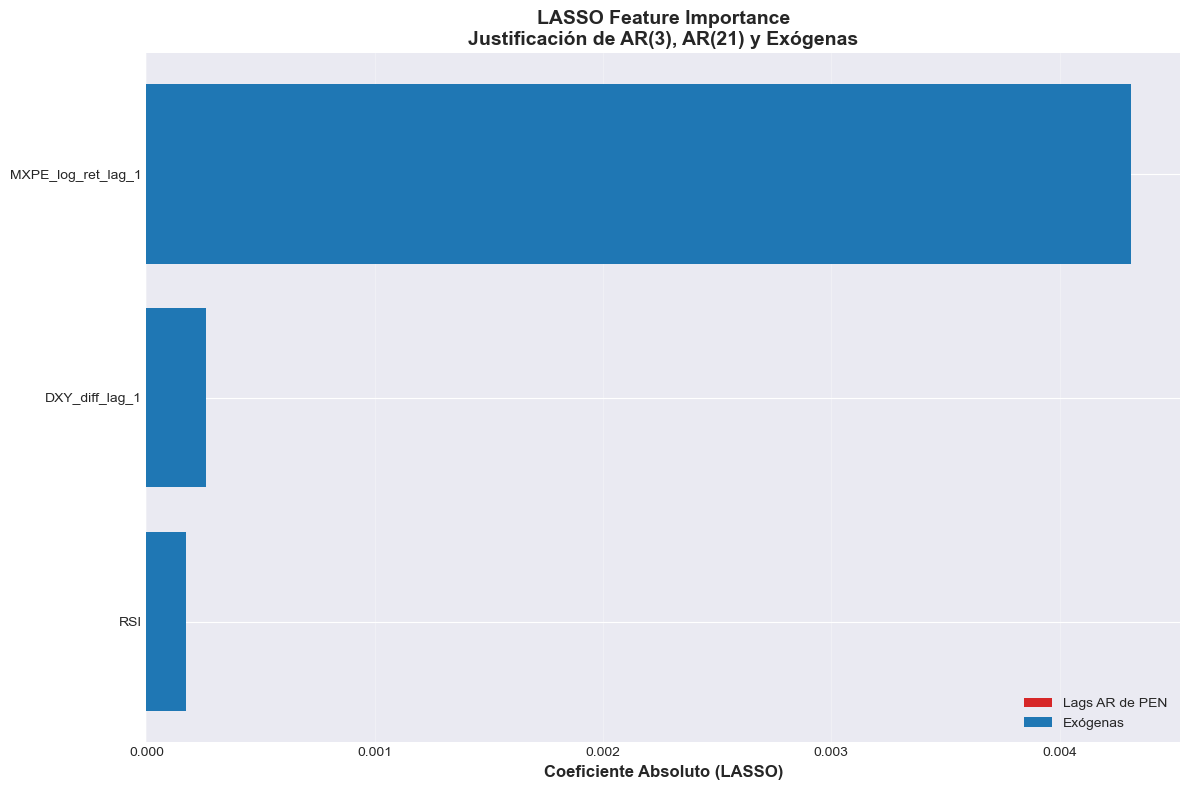

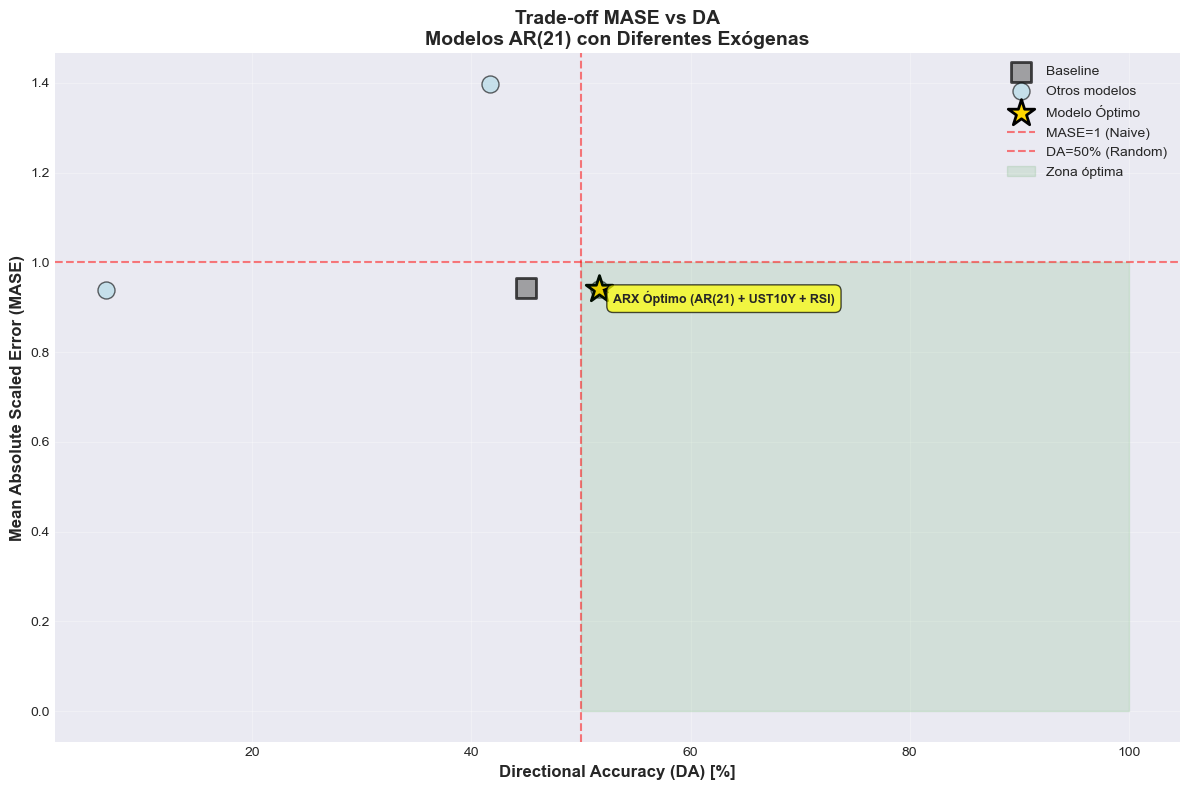

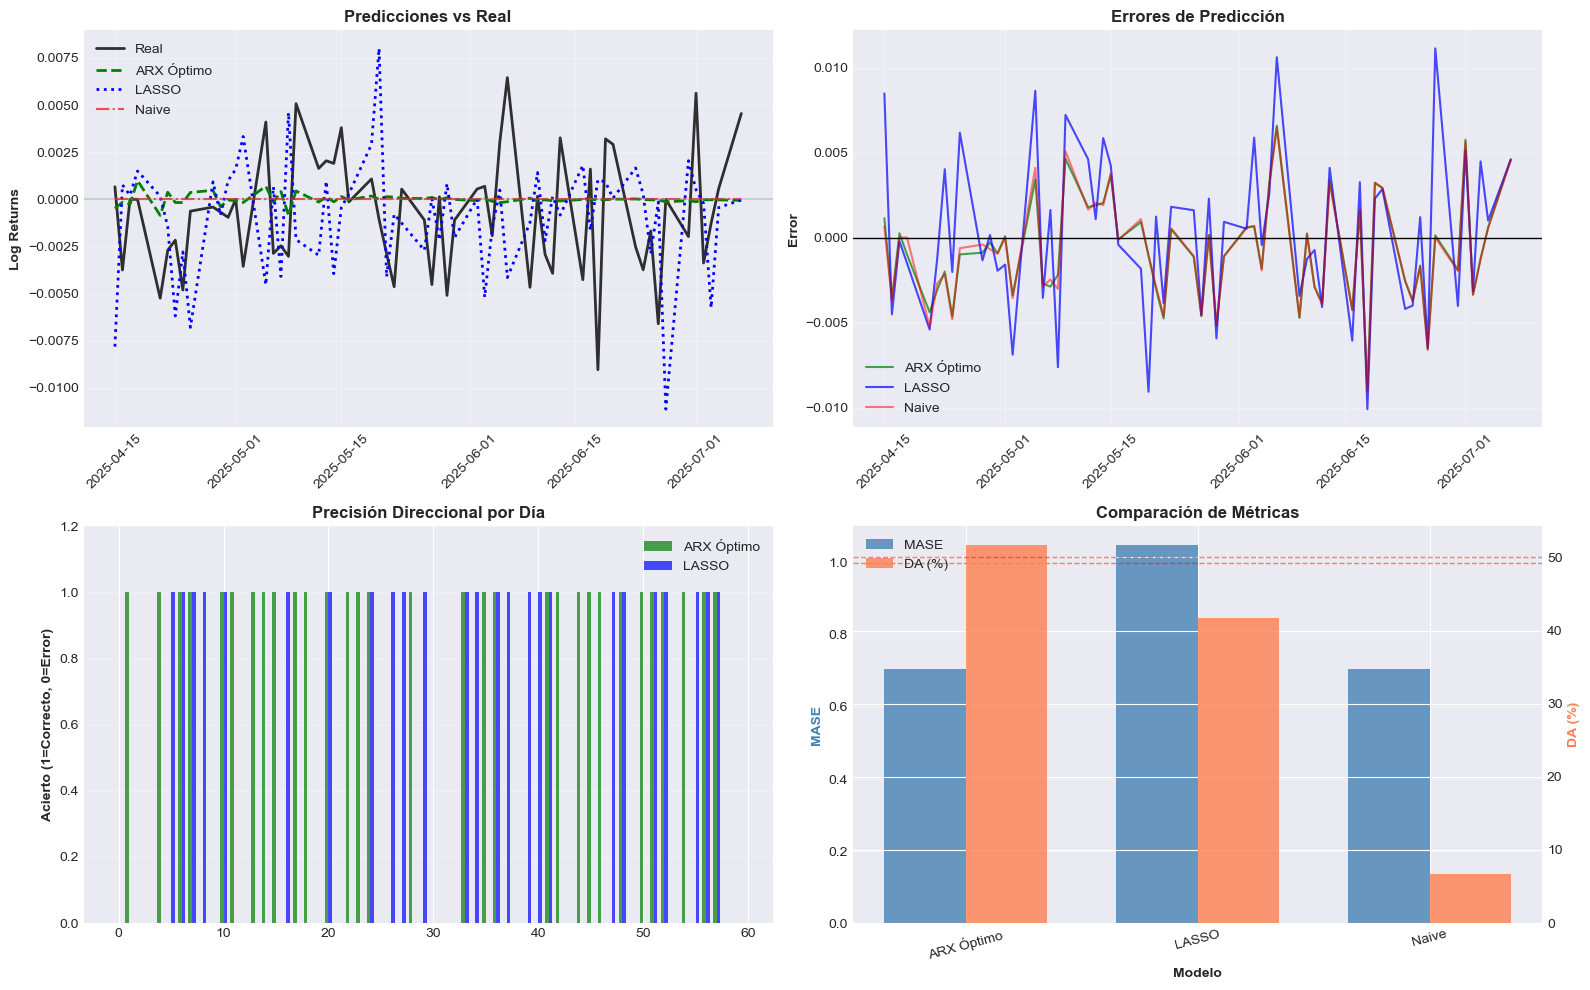


📋 RESUMEN FINAL

✅ ARCHIVOS GENERADOS:
   1. OOF Predictions:  C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\oof_predictions\train_oof_ARX.csv
   2. OOF Metadata:     C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\oof_predictions\train_oof_ARX_metadata.json
   3. Holdout Predictions: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\predictions_dump\pred_ARX.csv

📊 ESTADÍSTICAS:
   • Observaciones OOF: 7623
   • MAE OOF:  0.001967
   • DA OOF:   46.90%
   • MASE OOF: 0.8429

📊 HOLDOUT (60 días):
   • MASE: 0.9398
   • DA:   51.67%
   • AIC:  -68315.70

✅ PROCESO COMPLETADO

💡 Siguiente paso: Usar train_oof_ARX.csv para entrenar meta-learner


In [30]:
# ============================================================================
# EJECUCIÓN Y VISUALIZACIÓN
# ============================================================================

print("="*80)
print("BASELINE USD/PEN - EJECUCIÓN CON OOF")
print("="*80)

# Definir directorios
OUTPUT_DIR = r'C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\oof_predictions'
HOLDOUT_DIR = r'C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\predictions_dump'

# Instanciar pipeline
pipeline = USDPENPipeline('DATA.csv')

# ============================================================================
# PASO 1: GENERAR PREDICCIONES OOF PARA META-LEARNER
# ============================================================================
print("\n" + "="*80)
print("🎯 PASO 1: GENERAR PREDICCIONES OOF PARA META-LEARNER")
print("="*80)

oof_preds, oof_metrics = pipeline.generate_oof_predictions(
    min_train=252,
    step_size=21,
    output_dir=OUTPUT_DIR
)

print(f"\n✅ OOF generado exitosamente")
print(f"   📊 Observaciones OOF: {len(oof_preds)}")
print(f"   📁 Guardado en: {OUTPUT_DIR}")

# ============================================================================
# PASO 2: EVALUACIÓN EN HOLDOUT (como siempre)
# ============================================================================
print("\n" + "="*80)
print("🎯 PASO 2: EVALUACIÓN EN HOLDOUT")
print("="*80)

resultados = pipeline.run()

# Guardar predicciones del holdout en formato estándar
pred_df = pd.DataFrame({
    'ds': resultados['predictions']['dates'],
    'y_pred': resultados['predictions']['y_pred_arx'],
    'model': 'ARX',
    'type': 'log_returns'
})

os.makedirs(HOLDOUT_DIR, exist_ok=True)
holdout_file = os.path.join(HOLDOUT_DIR, 'pred_ARX.csv')
pred_df.to_csv(holdout_file, index=False)

print(f"\n✅ Guardado holdout: pred_ARX.csv")
print(f"   📊 Predicciones: {len(pred_df)}")
print(f"   📁 Guardado en: {HOLDOUT_DIR}")

# ============================================================================
# PASO 3: VISUALIZACIONES (como siempre)
# ============================================================================
print("\n" + "="*80)
print("🎯 PASO 3: VISUALIZACIONES")
print("="*80)

# Interpretar resultados
interpreter = ResultsInterpreter()

# Tabla comparativa
print("\n")
df_resultados = interpreter.print_comparison_table(pipeline.results)

# GRÁFICO 1: LASSO Feature Importance
fig1 = interpreter.plot_lasso_importance(resultados['feature_importance'], top_n=15)
plt.show()

# GRÁFICO 2: MASE vs DA (Trade-off)
fig2 = interpreter.plot_mase_vs_da(df_resultados)
plt.show()

# GRÁFICO 3: Comparación Holdout
fig3 = interpreter.plot_holdout_comparison(
    resultados['test_df'],
    resultados['predictions']['y_test'],
    resultados['predictions']['y_pred_arx'],
    resultados['predictions']['y_pred_lasso'],
    resultados['predictions']['y_pred_naive']
)
plt.show()

# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n" + "="*80)
print("📋 RESUMEN FINAL")
print("="*80)

print(f"\n✅ ARCHIVOS GENERADOS:")
print(f"   1. OOF Predictions:  {os.path.join(OUTPUT_DIR, 'train_oof_ARX.csv')}")
print(f"   2. OOF Metadata:     {os.path.join(OUTPUT_DIR, 'train_oof_ARX_metadata.json')}")
print(f"   3. Holdout Predictions: {holdout_file}")

print(f"\n📊 ESTADÍSTICAS:")
print(f"   • Observaciones OOF: {len(oof_preds)}")
print(f"   • MAE OOF:  {oof_metrics['mae']:.6f}")
print(f"   • DA OOF:   {oof_metrics['da']:.2f}%")
print(f"   • MASE OOF: {oof_metrics['mase']:.4f}")

best_result = df_resultados[df_resultados['modelo'].str.contains('ARX Óptimo')].iloc[0]
print(f"\n📊 HOLDOUT (60 días):")
print(f"   • MASE: {best_result['MASE']:.4f}")
print(f"   • DA:   {best_result['DA']:.2f}%")
print(f"   • AIC:  {best_result['AIC']:.2f}")

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO")
print("="*80)
print("\n💡 Siguiente paso: Usar train_oof_ARX.csv para entrenar meta-learner")
print("="*80)

In [31]:
# ============================================================================
# EXPORTAR PREDICCIONES PARA META-LEARNER
# ============================================================================

print("\n" + "="*80)
print("EXPORTANDO PREDICCIONES PARA META-LEARNER")
print("="*80)

# Extraer predicciones del ARX óptimo (AR(21) + UST10Y + RSI)
dates = resultados['predictions']['dates']
y_pred_arx = resultados['predictions']['y_pred_arx']

# Validar que tengamos 60 predicciones
assert len(y_pred_arx) == 60, f"Error: Se esperaban 60 predicciones, se obtuvieron {len(y_pred_arx)}"

print(f"\n📊 ESTADÍSTICAS DE PREDICCIONES (LOG RETURNS):")
print(f"  Media: {y_pred_arx.mean():.6f}")
print(f"  Std: {y_pred_arx.std():.6f}")
print(f"  Min: {y_pred_arx.min():.6f}")
print(f"  Max: {y_pred_arx.max():.6f}")

# Exportar (ya son log returns)
export_model_predictions(
    dates=dates,
    y_pred=y_pred_arx,
    model_name='ARX',
    prediction_type='log_returns',
    output_dir='predictions_dump'
)

print("✅ Predicciones ARX exportadas exitosamente")
print("="*80)


EXPORTANDO PREDICCIONES PARA META-LEARNER

📊 ESTADÍSTICAS DE PREDICCIONES (LOG RETURNS):
  Media: -0.000008
  Std: 0.000279
  Min: -0.000850
  Max: 0.000995
✅ [EXPORT] Predicciones guardadas en: predictions_dump\pred_ARX.csv
   - Dimensiones: (60, 4)
   - Tipo: log_returns
✅ Predicciones ARX exportadas exitosamente
